In [1]:
%matplotlib inline

import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/apple1/TFCA/nengo-dl/nengo_dl/__init__.py:17: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  warnings.warn("No GPU support detected. It is recommended that you "


In [73]:
nengo.dists.Choice([100])

Choice(options=array([100.]))

In [108]:
# lif parameters
lif_neurons = nengo.LIF(tau_rc=0.02, tau_ref=0.002, amplitude=0.01)

# softlif parameters (lif parameters + sigma)
softlif_neurons = nengo_dl.SoftLIFRate(tau_rc=0.02, tau_ref=0.002,amplitude=0.1,
                                       sigma=0.002)

# ensemble parameters
ens_params = dict(max_rates=nengo.dists.Choice([100]), intercepts=nengo.dists.Choice([0]))
#ens_params = dict(max_rates=nengo.dists.Uniform(0, 1), intercepts=nengo.dists.Choice([0]))

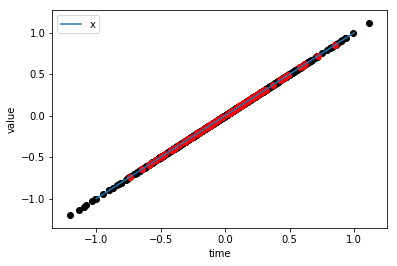

In [109]:
train = 0.35 * np.random.randn(1000)
test = 0.35 * np.random.randn(100)
target = np.linspace(-1, 1, 1000)
y = lambda x: x #* np.sin(x)
plt.figure()
plt.plot(target, y(target), label="x")
plt.scatter(train,y(train), color='black')
plt.scatter(test,y(test), color='red')
plt.xlabel("time")
plt.ylabel("value")
plt.legend();

In [120]:
def build_network(neuron_type):
    with nengo.Network() as net:

        #nengo_dl.configure_settings(trainable=False)

        inp = nengo.Node([0])
        
        x = nengo_dl.tensor_layer(inp, tf.layers.dense, units=10, shape_in=(1,))
        
        #x = nengo_dl.tensor_layer(x, nengo.RectifiedLinear())
        x = nengo_dl.tensor_layer(x, neuron_type, **ens_params)
        
        #x = nengo_dl.tensor_layer(x, tf.layers.dense, units=10)
        
       # x = nengo_dl.tensor_layer(x, neuron_type, **ens_params)
        
        #x, conn = nengo_dl.tensor_layer(
        #    x, neuron_type, **ens_params, transform=nengo_dl.dists.Glorot(), return_conn=True)

        #net.config[x].trainable = True
        #net.config[conn].trainable = True

        # add a dropout layer
        #x = nengo_dl.tensor_layer(x, tf.layers.dropout, rate=0.4)

        x = nengo_dl.tensor_layer(x, tf.layers.dense, units=1)

    return net, inp, x

# construct the network
net, inp, out = build_network(softlif_neurons)
with net:
    in_p = nengo.Probe(inp)
    out_p = nengo.Probe(out)

# construct the simulator
minibatch_size = 10
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size, tensorboard='/Users/apple1/TFCA')

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [121]:
traint = train[:,None,None]
testt = test[:,None,None]
train_x = {inp: traint}
train_y = {out_p: y(traint)}
test_x = {inp: testt}
test_y = {out_p: y(testt)}

In [122]:
#opt = tf.train.MomentumOptimizer(learning_rate=0.0002, momentum=0.9, use_nesterov=True)
opt = tf.train.RMSPropOptimizer(2e-3)

In [ ]:
print("error before training: ", sim.loss(test_x, test_y, objective='mse'))

sim.train(train_x, train_y, opt, n_epochs=100, objective='mse')

print("error after training:", sim.loss(test_x, test_y, objective='mse'))

sim.close()

INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmpeux5llyi/tmp


INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmpeux5llyi/tmp


error before training:  5.87288990020752
|#################Training (97%)################  | ETA: 0:00:00 (loss: 0.0003)

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


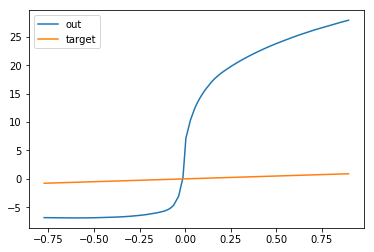

In [119]:
with nengo_dl.Simulator(net, minibatch_size=100) as sim:
    sim.run_steps(1,input_feeds={inp: traint[:100]})

indx = np.argsort(np.squeeze(sim.data[in_p]))
plt.plot(np.squeeze(sim.data[in_p])[indx],np.squeeze(sim.data[out_p])[indx],label='out')
plt.plot(np.squeeze(sim.data[in_p])[indx],np.squeeze(y(sim.data[in_p]))[indx],label='target')
plt.legend()

In [105]:
with nengo_dl.Simulator(net, minibatch_size=1) as sim:
    sim.run_steps(1,input_feeds={inp: traint[0:1]})
    print(sim.data[in_p])
    print(traint[0])
    print(sim.data[out_p])
    print(y(traint[0]))

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 
[[[1.8741757]]]
[[1.87417563]]
[[[-34.266487]]]
[[1.87417563]]
